In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import warnings

from matplotlib.offsetbox import AnchoredText
from theano import tensor as tt

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)})
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean())/series.std()

### 14E1.
*Rewrite the Oceanic tools model (from chapter 10) below, so that it assumes measured error on the log population sizes of each society:*

$$T_{i} \sim Poisson(\mu_{i})$$

$$log(\mu{i}) = \alpha + \beta\; log(P_{i})$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 1)$$

To add measurement error on a predictor variable, just add a distributional assumption for the observed values. In this case, we want to allow each observed log-population, $log(P_i)$, to be a draw from some distribution with an unknown true value plus error. In the chapter, the example used a Gaussian distribution. So I’ll use that again here. Specifically, assume that each observed $log(P_i)$ is defined by:

$$log(P_i) \sim Normal(\phi_i, \sigma_P)$$

where each $\phi_i$ is an unobserved true log-population for each society i and $\sigma_P$ is the standard error of measurement of log-population size.

To complete the model, we just add the above into the original model and replace $log(P_i)$ in the linear model with the unobserved $\phi_i$ values:

$$T_{i} \sim Poisson(\mu_{i})$$

$$log(\mu{i}) = \alpha + \beta \phi_i$$

$$log(P_{i}) \sim Normal(\phi_i, \sigma_P)$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 1)$$

$$\sigma_P \sim Exponential(1)$$

I added a default prior for $\sigma_P$ above. In a real analysis, you’d have information about the error that would help you either set an informative prior or (as in the chapter) use precise data for the standard error.

### 14E2.
*Rewrite the same model so that it allows imputation of missing values for log population. There aren't any missing values in the variable, but you can still write down a model formula that would imply imputation, if any values were missing.*

Imputation is almost the same trick as measurement error. When there is no measurement at all for a particular case in the data, the other cases, which are measured, provide information to define an adaptive prior for the variable. This prior then informs the missing values. This is exactly what was done in the chapter. Here’s what it might look like for the Oceanic societies model:

$$T_{i} \sim Poisson(\mu_{i})$$

$$log(\mu{i}) = \alpha + \beta \phi_i$$

$$\phi_i \sim Normal(\nu, \sigma_P)$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 1)$$

$$\nu \sim Normal(0, 10)$$

$$\sigma_P \sim Exponential(1)$$

Now each $\phi_i$ value is either an observed log-population value or otherwise a parameter that stands in place of a missing value. This is just like the example in the chapter, in which the vector N was a mix of observed neocortex percents and parameters that stood in place of missing values.

### 14M1.
*Using the mathematical form of the imputation model in the chapter, explain what is being assumed about how the missing values were generated.*

This is a subtle question. The key is to recognize that the distributional assumption about the predictor that contains missing values does not contain any information about each case. As a consequence, it implicitly assumes that missing values are randomly located among the cases. Now keep in mind that “random” only ever means that we do not know why the data turned out the way it did. It isn’t a claim about causation, just a claim about information.

### 14M2.
*In earlier chapters, we threw away cases from the primary milk data, so we could use the neocortex variable. Now repeat the WAIC model comparison example from chapter 6, but use imputation on the neocortex variable, so that you can include all of the cases in the original data. The simplest form of imputation is acceptable. How are the model comparison results affected by being able to include all of the cases?*

First, let’s repeat fitting the models from chapter 6, but this time we’ll use weakly regularizing priors, since they are superior:

In [77]:
d = pd.read_csv('../Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,0.6454
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,0.6454
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,0.6764
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,0.6885


In [78]:
logmass = np.log(d['mass'].values)
neocortex = d['neocortex'].values

with pm.Model() as m6_11:
    a = pm.Normal('a', mu=0., sd=100.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu = a
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    
    trace_m6_11 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)

with pm.Model() as m6_12:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu = a + bn*neocortex
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    
    trace_m6_12 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .9})
    
with pm.Model() as m6_13:
    a = pm.Normal('a', mu=0., sd=100.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu = a + bm*logmass
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    
    trace_m6_13 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)
    
with pm.Model() as m6_14:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu = a + bn*neocortex + bm*logmass
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    
    trace_m6_14 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 622.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:51<00:00, 115.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 548.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, bn, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:10<00:00, 84.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


With the reduced data, these models yield these WAIC rankings:

In [79]:
comp_df = az.compare({'m6_11' : trace_m6_11, 'm6_12' : trace_m6_12,
                      'm6_13' : trace_m6_13, 'm6_14' : trace_m6_14})
comp_df

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_14,-15.2292,2.57908,0,0.826289,3.37574,0,True,deviance
m6_13,-9.16652,1.99494,6.0627,0.0496346,3.63592,2.04265,True,deviance
m6_11,-8.64852,1.3519,6.5807,0.0698048,4.54118,3.60393,False,deviance
m6_12,-7.8326,1.77534,7.39662,0.0542715,4.07868,3.83311,False,deviance


This is just as before: the model with both predictors does best by far, because of the masking relationship between body mass and neocortex percent.

Now let’s repeat this analysis using all of the cases, with imputation on neocortex:

In [2]:
d = pd.read_csv('../Data/milk.csv', ';')
d.loc[:,'neocortex.prop'] = d['neocortex.perc'] / 100
d.loc[:,'logmass'] = np.log(d['mass'])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex.prop,logmass
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516,0.667829
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,0.737164
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,0.920283
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,0.482426
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,0.783902


In [3]:
# prep data
neocortex = d['neocortex.prop'].values
logmass = d['logmass'].values
kcal = d['kcal.per.g'].values

# masked array for missing values
mask = np.isfinite(neocortex)
neocortex[~mask] = -999
neocortex = np.ma.masked_values(neocortex, value=-999)

In [4]:
with pm.Model() as m6_11_full:
    a = pm.Normal('a', mu=0., sd=100.)
    sigma = pm.Exponential('sigma', 1.)
    
    # need neocortex even though not used, because pymc can't compare models with different numbers of observed RVs
    mu_N = pm.Normal('mu_N', .5, 1.)
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_11_full = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)
    
with pm.Model() as m6_12_full:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu_N = pm.Normal('mu_N', .5, 1.)
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a + bn*neocortex_
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_12_full = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .9})
    
with pm.Model() as m6_13_full:
    a = pm.Normal('a', mu=0., sd=100.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    # need neocortex even though not used, because pymc can't compare models with different numbers of observed RVs
    mu_N = pm.Normal('mu_N', .5, 1.)
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a + bm*logmass
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_13_full = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)
    
with pm.Model() as m6_14_full:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    mu_N = pm.Normal('mu_N', .5, 1.)
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a + bn*neocortex_ + bm*logmass
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_14_full = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .9})

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, sigma_N, mu_N, sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 344.94draws/s]
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, sigma_N, mu_N, sigma, bn, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:23<00:00, 71.48draws/s]
/anaconda

And let’s compare these models. Remember, it makes no sense to compare the four models above to the previous four models. Why? Because they are  fit to different data. We can however inspect the two different WAIC tables and ask what impact including the additional data has had.

In [72]:
logp = m6_11_full.logp
np.array([logp(trace_m6_11_full.point(i, chain=c)) for c in trace_m6_11_full.chains for i in range(len(trace_m6_11_full))])

array([34.05983038, 30.79280782, 35.91776941, ..., 43.6249531 ,
       44.50293479, 43.61502187])

In [73]:
np.round(trace_m6_11_full.get_sampler_stats("model_logp"), 3)

array([34.06 , 30.793, 35.918, ..., 43.625, 44.503, 43.615])

In [65]:
az.from_pymc3(trace=trace_m6_11_full).sample_stats#["log_likelihood"]

<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    depth             (chain, draw) int64 3 3 3 3 3 3 3 3 3 ... 3 3 3 4 3 3 3 2
    mean_tree_accept  (chain, draw) float64 0.9316 0.7177 0.9846 ... 1.0 0.5104
    max_energy_error  (chain, draw) float64 0.2481 0.5093 ... -0.4805 1.459
    diverging         (chain, draw) bool False False False ... False False False
    step_size_bar     (chain, draw) float64 0.5887 0.5887 ... 0.5983 0.5983
    lp                (chain, draw) float64 34.06 30.79 35.92 ... 44.5 43.62
    tree_size         (chain, draw) float64 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 3.0
    tune              (chain, draw) bool True False False ... False False False
    energy            (chain, draw) float64 -28.73 -20.83 ... -40.56 -35.19
    energy_error      (chain, draw) float64 0.2481 0.4185 ... -0.2842 0.5735
    s

In [37]:
lnp12 = trace_m6_12_full.get_sampler_stats("model_logp")

In [47]:
trace_data = az.from_pymc3(trace=trace_m6_12_full)
trace_data.sample_stats["log_likelihood"] = lnp12

In [49]:
trace_data.sample_stats

<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, log_likelihood: 2000)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * log_likelihood    (log_likelihood) float64 42.36 43.97 44.38 ... 37.95 38.91
Data variables:
    depth             (chain, draw) int64 6 6 5 6 5 6 6 6 6 ... 6 6 6 6 6 6 6 6
    mean_tree_accept  (chain, draw) float64 0.9984 1.0 0.9954 ... 0.5942 0.9057
    max_energy_error  (chain, draw) float64 -0.0326 -0.0372 ... 1.094 0.2827
    diverging         (chain, draw) bool False False False ... False False False
    step_size_bar     (chain, draw) float64 0.07297 0.07297 ... 0.07 0.07
    lp                (chain, draw) float64 42.36 43.97 44.38 ... 37.95 38.91
    tree_size         (chain, draw) float64 63.0 63.0 31.0 ... 63.0 63.0 63.0
    tune              (chain, draw) bool True False False ... False False False
    energy            (chain, draw) float64 -31.37 -35.95

In [16]:
az.compare({'m6_11_full' : trace_m6_11_full,
            'm6_12_full' : trace_m6_12_full,
            'm6_13_full' : trace_m6_13_full,
            'm6_14_full' : trace_m6_14_full})

TypeError: Data must include log_likelihood in sample_stats

In [6]:
for i, m in enumerate([m6_11_full, m6_12_full, m6_13_full, m6_14_full]):
    print(f"m_{i+11}_full: ", m.observed_RVs) #basic, free

m_11_full:  [neocortex, kcal]
m_12_full:  [neocortex, kcal]
m_13_full:  [neocortex, kcal]
m_14_full:  [neocortex, kcal]


In [7]:
# az.compare throws "TypeError: Data must include log_likelihood in sample_stats" for these models -> revert to pm.compare
comp_df_full = pm.compare({m6_11_full : trace_m6_11_full, 
                           m6_12_full : trace_m6_12_full, 
                           m6_13_full : trace_m6_13_full, 
                           m6_14_full : trace_m6_14_full})

comp_df_full.loc[:,'model'] = pd.Series(['m6_11_full', 'm6_12_full', 'm6_13_full', 'm6_14_full'])
comp_df_full = comp_df_full.set_index('model')
comp_df_full

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/s

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6_14_full,-73.05,6.27,0,1,9.3,0,1
m6_13_full,-66.73,3.78,6.31,0,9.63,2.18,1
m6_11_full,-65.37,3.04,7.67,0,9.53,3.94,1
m6_12_full,-64.5,3.91,8.55,0,9.52,4.17,1


The rank order is the same, and the weights are very similar. It may be easier to do a head-to-head comparison by just plotting both tables as dot charts though:

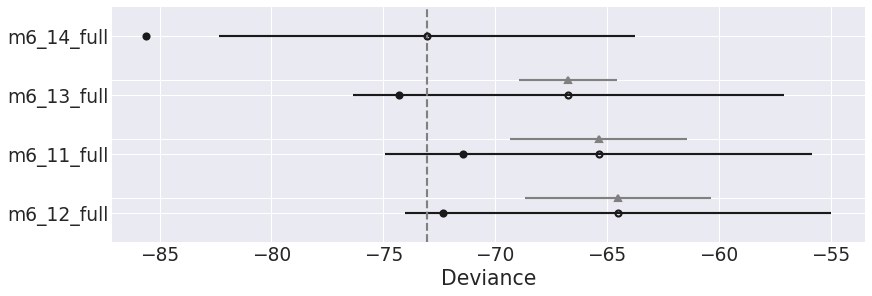

In [81]:
pm.compareplot(comp_df_full, figsize=(12, 4));

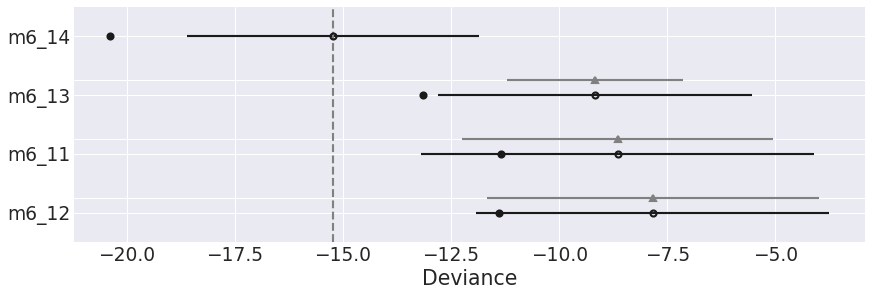

In [83]:
az.plot_compare(comp_df, figsize=(12, 4));

Among all the differences, a striking one is that all of the standard errors are relatively smaller when we use the full data (NOT TRUE HERE). This is to be expected, as there is more information. You can see this in the coefficients as well. Consider for example the standard deviations on the regression parameters in `m6_14_full` and `m6_14`:

In [84]:
az.summary(trace_m6_14, credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.24,0.48,-0.97,0.51,0.02,0.02,485.40,485.40,492.83,699.59,1.0
bn,1.48,0.74,0.30,2.59,0.03,0.02,464.54,464.54,468.15,612.80,1.0
bm,-0.06,0.03,-0.11,-0.03,0.00,0.00,704.52,704.52,718.91,722.73,1.0
sigma,0.15,0.03,0.10,0.20,0.00,0.00,610.33,610.33,647.41,782.44,1.0


In [85]:
az.summary(trace_m6_14_full, credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.11,0.39,-0.72,0.53,0.02,0.01,535.29,535.29,537.55,874.66,1.0
bn,1.24,0.61,0.24,2.16,0.03,0.02,519.96,519.96,519.53,861.51,1.0
bm,-0.06,0.02,-0.09,-0.02,0.00,0.00,827.28,822.40,819.84,1036.26,1.0
mu_N,0.67,0.01,0.65,0.69,0.00,0.00,950.52,947.03,942.36,1410.78,1.0
neocortex_missing[0],0.64,0.06,0.55,0.73,0.00,0.00,1097.22,1068.85,1119.61,1192.53,1.0
neocortex_missing[1],0.63,0.06,0.55,0.74,0.00,0.00,1274.13,1223.51,1294.17,1270.11,1.0
neocortex_missing[2],0.63,0.06,0.53,0.72,0.00,0.00,1734.24,1734.24,1735.44,1046.94,1.0
neocortex_missing[3],0.66,0.06,0.57,0.74,0.00,0.00,1851.38,1851.38,1820.02,1272.08,1.0
neocortex_missing[4],0.70,0.06,0.61,0.79,0.00,0.00,2190.14,2190.14,2187.04,1513.41,1.0
neocortex_missing[5],0.66,0.06,0.58,0.77,0.00,0.00,1384.14,1364.76,1441.13,1146.40,1.0


The width of the marginal posterior is narrower in every case, and this translates into narrower intervals as well.

For extra practice, Richard McElreath recommends repeating the above with a better imputation model, such as the second imputation model from the example in the chapter. As we are ideal students and, let's face it, you're having the time of your life, we'll do it now!

So, the imputation model we used here (the line where we define the neocortex variable, observed and missing) assumes no relationship with the other predictor, logmass. As a result, the imputed neocortex values don't increase with log mass. But we know these predictors are positively associated, so we can do better - and, as ideal students, we like to do better! 

Our goal is to squeeze more information from the data, by taking into account the relationship between the two predictors. The idea is to change the imputation model from $neocortex \sim Normal(\mu, \sigma_n)$ to $neocortex \sim Normal(\mu_i, \sigma_n)$, where $\mu_i = \alpha_n + \gamma_n logmass$. Let's do that in code form!

In [8]:
with pm.Model() as m6_11_better:
    a = pm.Normal('a', mu=0., sd=100.)
    sigma = pm.Exponential('sigma', 1.)
    
    # need neocortex even though not used, because pymc can't compare models with different numbers of observed RVs
    neocortex_ = pm.Normal('neocortex', .5, 1., observed=neocortex)
    
    mu = a
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_11_better = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)
    
with pm.Model() as m6_12_better:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    # imputation model
    an = pm.Normal('an', mu=.5, sd=1.)
    gm = pm.Normal('gm', mu=0., sd=1.)
    mu_N = an + gm*logmass
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a + bn*neocortex_
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_12_better = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .9})
    
with pm.Model() as m6_13_better:
    a = pm.Normal('a', mu=0., sd=100.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    # need neocortex even though not used, because pymc can't compare models with different numbers of observed RVs
    neocortex_ = pm.Normal('neocortex', .5, 1., observed=neocortex)
    
    mu = a + bm*logmass
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_13_better = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, cores=2)
    
with pm.Model() as m6_14_better:
    a = pm.Normal('a', mu=0., sd=100.)
    bn = pm.Normal('bn', mu=0., sd=1.)
    bm = pm.Normal('bm', mu=0., sd=1.)
    sigma = pm.Exponential('sigma', 1.)
    
    # imputation model
    an = pm.Normal('an', mu=.5, sd=1.)
    gm = pm.Normal('gm', mu=0., sd=1.)
    mu_N = an + gm*logmass
    sigma_N = pm.Exponential('sigma_N', 1.)
    neocortex_ = pm.Normal('neocortex', mu_N, sigma_N, observed=neocortex)
    
    mu = a + bn*neocortex_ + bm*logmass
    
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_m6_14_better = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, cores=2, nuts_kwargs={"target_accept": .95})

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 184.27draws/s]
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, sigma_N, gm, an, sigma, bn, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:34<00:00, 63.76draws/s]
/anaconda/envs/stat-re

In [9]:
compar = pm.compare({m6_11_better : trace_m6_11_better,
                     m6_12_better : trace_m6_12_better,
                     m6_13_better : trace_m6_13_better,
                     m6_14_better : trace_m6_14_better})

compar.loc[:,'model'] = pd.Series(['m6_11_better', 'm6_12_better', 'm6_13_better', 'm6_14_better'])
compar = compar.set_index('model')
compar

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6_14_better,-86.04,7.08,0,1,12.08,0,1
m6_12_better,-75.81,4.72,10.23,0,12.53,4.42,1
m6_13_better,9.3,2.05,95.33,0,10.37,17.95,0
m6_11_better,10.92,1.39,96.96,0,10.02,18.12,0


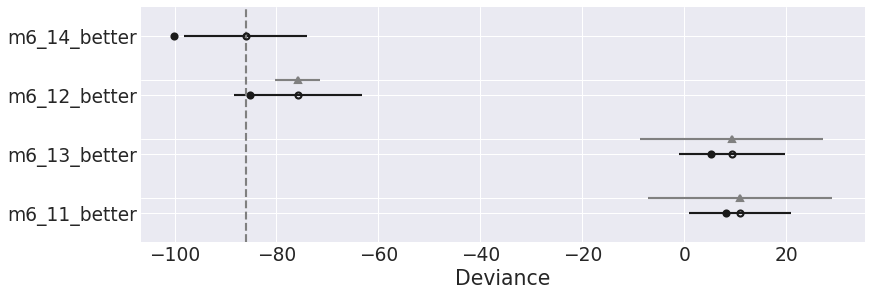

In [10]:
pm.compareplot(compar, figsize=(12, 4));

In [12]:
az.summary(trace_m6_14_full, credible_interval=0.89, round_to=2)

NameError: name 'trace_m6_14_full' is not defined

In [11]:
az.summary(trace_m6_14_better, credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.27,0.43,-0.99,0.36,0.02,0.01,522.54,522.54,524.31,870.48,1.0
bn,1.51,0.67,0.39,2.50,0.03,0.02,509.71,509.71,512.49,982.77,1.0
bm,-0.07,0.02,-0.10,-0.03,0.00,0.00,726.34,726.34,722.30,1130.59,1.0
an,0.64,0.01,0.62,0.66,0.00,0.00,959.01,948.42,966.41,1048.11,1.0
gm,0.02,0.01,0.01,0.03,0.00,0.00,1261.12,1208.72,1268.71,997.65,1.0
neocortex_missing[0],0.64,0.04,0.57,0.70,0.00,0.00,1510.36,1510.36,1497.44,1099.02,1.0
neocortex_missing[1],0.64,0.04,0.57,0.70,0.00,0.00,1320.81,1301.00,1335.81,1148.37,1.0
neocortex_missing[2],0.63,0.04,0.56,0.69,0.00,0.00,1567.74,1540.64,1587.07,1343.83,1.0
neocortex_missing[3],0.65,0.04,0.59,0.72,0.00,0.00,1606.14,1595.14,1653.15,1266.75,1.0
neocortex_missing[4],0.66,0.04,0.59,0.73,0.00,0.00,1590.33,1590.33,1612.62,1053.05,1.0


## TODO:
interpret results once az.compare bug is resolved. Here we can compare the four models above to the previous four models, because they are fit to the same data. Consider the standard deviations on the regression parameters in `m6_14_full` and `m6_14_better`:

### 14M3.
*Repeat the first divorce data measurement error model (the one with error only on the outcome variable), but this time double the standard errors. Can you explain how doubling the standard errors impacts inference?*

This problem is as easy as modifying the code from the chapter to have double values for the standard error variable, `Divorce SE`.

In [16]:
d = pd.read_csv('../Data/WaffleDivorce.csv', ';')
d['log_population'] = np.log(d['Population'])

div_obs = d['Divorce'].values
div_sd = d['Divorce SE'].values
mar_obs = d['Marriage'].values
mar_sd = d['Marriage SE'].values
A = d['MedianAgeMarriage'].values
N = len(d)

d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,log_population
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,1.564441
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.342490
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,1.845300
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,1.071584
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,3.617652


In [31]:
with pm.Model() as m_14_1_double:
    
    a = pm.Normal('a', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bR = pm.Normal('bR', 0., 10.)
    
    mu = a + bA*A + bR*R
    sigma = pm.Exponential('sigma', 2.5)
    div_est = pm.Normal('div_est', mu, sigma, shape=N)
    
    div_obs_ = pm.Normal('div_obs', div_est, 2.*div_sd, observed=div_obs)
    
    start = dict(div_est=div_obs)
    trace_14_1_double = pm.sample(1000, tune=3000, cores=2, start=start, random_seed=RANDOM_SEED, nuts_kwargs=dict(target_accept=.99))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [div_est, sigma, bR, bA, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [22:39<00:00,  3.03draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


You’ll notice that this model does not sample very efficiently. Increasing the standard errors on the outcome variable has made the posterior less well identified, and this has made sampling harder in this case. In fact, as NUTS diagnostics say it above so poetically: "the sampler did not converge". Let's make sure of that by checking our very ugly trace:

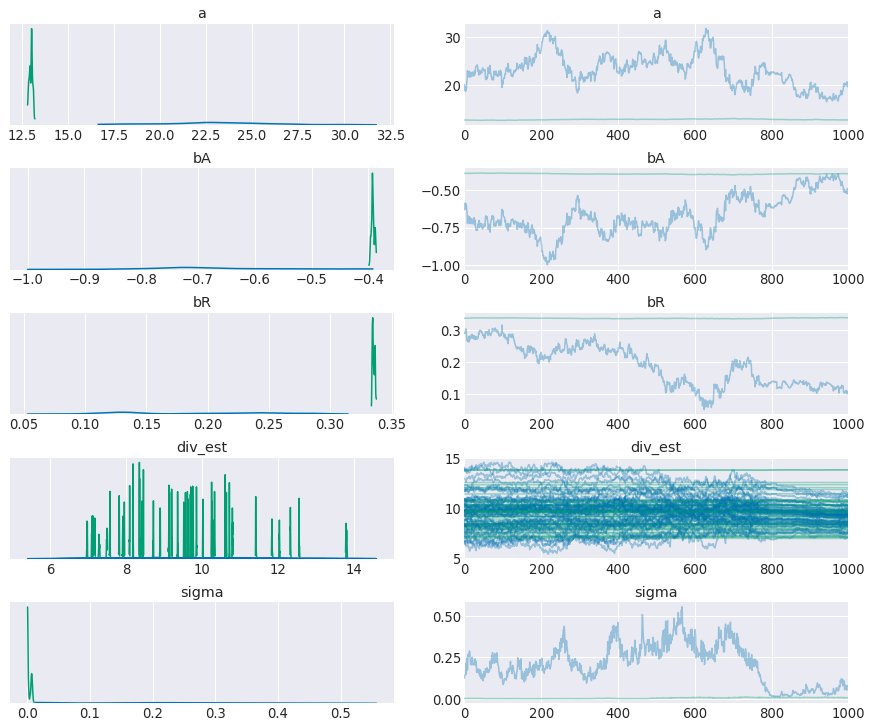

In [32]:
az.plot_trace(trace_14_1_double, compact=True);

Now let's compare these estimates to the ones from the chapter. First, we have to refit the original model:

In [28]:
with pm.Model() as m_14_1:
    
    a = pm.Normal('a', 0., 10.)
    bA = pm.Normal('bA', 0., 1.)
    bR = pm.Normal('bR', 0., 1.)
    
    mu = a + bA*A + bR*R
    sigma = pm.Exponential('sigma', 1.)
    div_est = pm.Normal('div_est', mu, sigma, shape=N)
    
    div_obs_ = pm.Normal('div_obs', div_est, div_sd, observed=div_obs)
    
    start = dict(div_est=div_obs)
    trace_14_1 = pm.sample(1000, tune=3000, cores=2, start=start, random_seed=RANDOM_SEED, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [div_est, sigma, bR, bA, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [06:22<00:00, 20.90draws/s]


And here are the estimates:

In [29]:
az.summary(trace_14_1, credible_interval=0.89, round_to=2, var_names=["a", "bA", "bR", "sigma"])

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,21.05,6.30,10.42,30.65,0.21,0.15,886.66,886.66,893.62,1195.94,1.0
bA,-0.54,0.20,-0.84,-0.19,0.01,0.00,922.87,922.87,931.72,1041.82,1.0
bR,0.13,0.07,0.01,0.24,0.00,0.00,1072.27,1072.27,1071.32,1467.20,1.0
sigma,1.10,0.20,0.79,1.41,0.01,0.00,837.82,837.82,808.80,1041.00,1.0


In [33]:
az.summary(trace_14_1_double, credible_interval=0.89, round_to=2, var_names=["a", "bA", "bR", "sigma"])

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,18.11,5.60,12.81,25.64,3.69,3.03,2.31,2.31,2.77,11.55,1.96
bA,-0.53,0.17,-0.76,-0.39,0.11,0.09,2.42,2.42,2.61,11.41,2.13
bR,0.26,0.09,0.13,0.34,0.06,0.05,2.13,2.10,2.57,15.13,2.22
sigma,0.11,0.14,0.00,0.31,0.08,0.06,3.19,3.19,2.57,20.75,2.23


The marginal posterior for `bA` is unchanged. But the posterior for `bR`, the coefficient for marriage rate, has almost doubled. Why? Increasing the standard errors has allowed different States to exert influence on the regression. All of the States have less certain divorce rates now, but the States that were previously quite precisely estimated — usually very large States — are now substantially less precise. This shifts the balance of information among the States and alters the results.

### 14H1.
*The data in elephants.csv are counts of matings observed for bull elephants of differing ages. There is a strong positive relationship between age and matings. However, age is not always assessed accurately. First, fit a Poisson model predicting MATINGS with AGE as a predictor. Second, assume that the observed AGE values are uncertain and have a standard error of $\pm$ 5 years. Re-estimate the relationship between MATINGS and AGE, incorporating this measurement error. Compare the infererences of the two models.*

To prepare for the first model (both physically and mentally), let's load the data and explore them. You'll notice I standardized the predictor variable. It's because the exponential link will make the lambda parameter really big, really quickly, making sampling virtually impossible. Don't take my word for it: run the following model with `AGE_STD` as the predictor, and then with `AGE`. This will rock your world.

In [39]:
d = pd.read_csv('../Data/elephants.csv', ';')
# Standardize predictor, to help with sampling
d["AGE_STDZ"] = stdz(d.AGE)
d.head()

,AGE,MATINGS,AGE_STDZ
0,27,0,-1.345826
1,28,1,-1.193818
2,28,1,-1.193818
3,28,1,-1.193818
4,28,3,-1.193818


In [40]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
AGE         41 non-null int64
MATINGS     41 non-null int64
AGE_STDZ    41 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.0 KB


In [41]:
d.describe().round(2)

,AGE,MATINGS,AGE_STDZ
count,41.00,41.00,41.00
mean,35.85,2.68,0.00
std,6.58,2.25,1.00
min,27.00,0.00,-1.35
25%,29.00,1.00,-1.04
50%,34.00,2.00,-0.28
75%,42.00,3.00,0.93
max,52.00,9.00,2.45


This is a very simple set of data. `AGE` contains ages in years of individual male elephants. `MATINGS` contains counts of matings for those individuals. Here is the implied Poisson model predicting `MATINGS` with `AGE`, as well as prior predictive checks (remember: beware the exp link!):

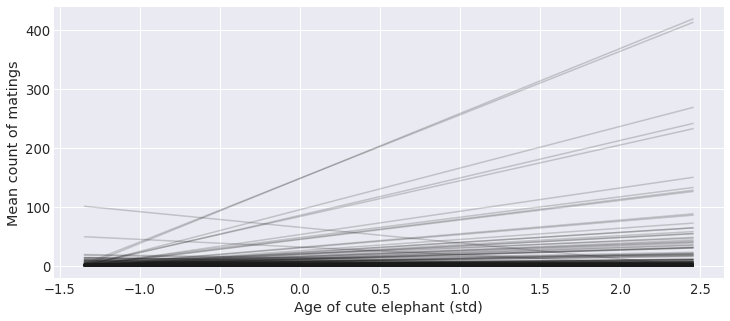

In [42]:
# As usual, prior predictive checks, to see if prior choice makes sense
a_s = pm.Normal.dist(mu=0., sd=1.).random(size=200)
bA_s = pm.Normal.dist(mu=0., sd=1.).random(size=200)

plt.figure(figsize=(12,5))
for y_s in zip(np.exp(a_s + bA_s*d.AGE_STDZ.min()), np.exp(a_s + bA_s*d.AGE_STDZ.max())):
    plt.plot([d.AGE_STDZ.min(), d.AGE_STDZ.max()], y_s, color='k', alpha=.2)
plt.xlabel("Age of cute elephant (std)")
plt.ylabel("Mean count of matings");

In [43]:
with pm.Model() as m_eleph:
    a = pm.Normal("a", 0., 1.)
    bA = pm.Normal("bA", 0., 1.)
    
    # Casting predictor to shared variable for out of sample predictions later
    age_stdz = pm.Data("age_stdz", d.AGE_STDZ)
    lam = pm.math.exp(a + bA*age_stdz)
    
    matings_obs = pm.Poisson("matings_obs", mu=lam, observed=d.MATINGS)
    trace_eleph = pm.sample(2000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_eleph = pm.trace_to_dataframe(trace_eleph)
az.summary(trace_eleph, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bA, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 622.49draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.86,0.11,0.67,1.02,0.0,0.0,1526.02,1526.02,1550.02,1397.13,1.0
bA,0.45,0.09,0.31,0.60,0.0,0.0,1427.44,1400.31,1429.27,1282.01,1.0


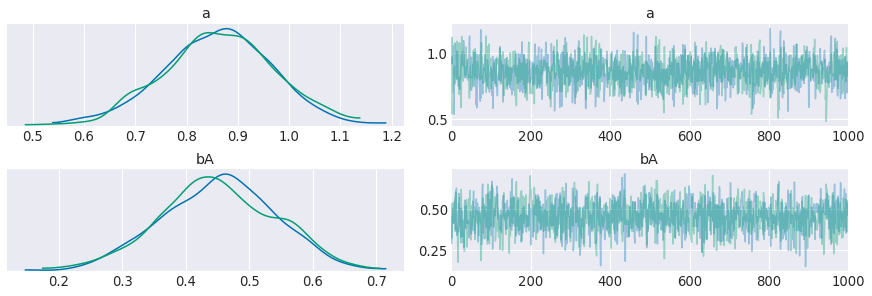

In [44]:
az.plot_trace(trace_eleph);

Let’s plot the implied relationship:

100%|██████████| 2000/2000 [00:07<00:00, 271.57it/s]


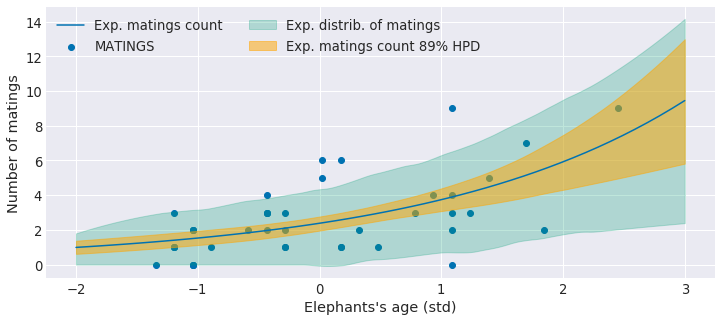

In [46]:
# define values to compute OOS predictions over
age_seq = np.linspace(-2, 3)

# lambda calcs
lambdas_post_pred = []
for age in age_seq:
    lambdas_post_pred.append(np.exp(post_eleph['a'] + post_eleph['bA']*age).values)
lambdas_post_pred = np.asarray(lambdas_post_pred).T

# outcome calcs
with m_eleph:
    pm.set_data({"age_stdz": age_seq})
    matings_post_pred = pm.sample_posterior_predictive(trace_eleph, random_seed=RANDOM_SEED)["matings_obs"]
    
# plot
plt.figure(figsize=(12,5))

plt.scatter(d.AGE_STDZ, d.MATINGS)
az.plot_hpd(age_seq, matings_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.25, "label": "Exp. distrib. of matings"})
az.plot_hpd(age_seq, lambdas_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.5, "color": "orange", "label": "Exp. matings count 89% HPD"})
plt.plot(age_seq, lambdas_post_pred.mean(axis=0), label="Exp. matings count")

plt.xlabel("Elephants's age (std)")
plt.ylabel("Number of matings")
plt.legend(ncol=2);

That looks like a reliably positive relationship. Older elephants get more matings, on average.

Now let’s assume each `AGE` value was measured with Gaussian error with standard deviation 5, as the problem suggests. Here’s the new model. The only trick to observe, as in the chapter, is to manually add the shape of the predictor (because *each* `AGE` value needs to be re-estimated). It's also a model that's harder to sample from, so we have to take good care of what we pass to `pm.sample`:

In [9]:
def eleph_with_error(error: float, tuning: float, acceptance: float = .85):
    
    with pm.Model() as m_eleph_error:
        a = pm.Normal("a", 0., 1.)
        bA = pm.Normal("bA", 0., 1.)

        age_est = pm.Flat("age_est", shape=len(d))
        age_obs = pm.Normal("age_obs", mu=age_est, sd=error, observed=d.AGE_STDZ)

        lam = pm.math.exp(a + bA*age_est)
        matings_obs = pm.Poisson("matings_obs", mu=lam, observed=d.MATINGS)

        start = dict(age_est=d.AGE_STDZ.values)
        trace_eleph_error = pm.sample(2000, tune=tuning, cores=2, start=start, random_seed=RANDOM_SEED, 
                                      nuts_kwargs=dict(target_accept=acceptance))
    
    return m_eleph_error, trace_eleph_error

In [141]:
_, trace_eleph_error = eleph_with_error(error=5., tuning=5000)
post_eleph_error = pm.trace_to_dataframe(trace_eleph_error)
az.summary(trace_eleph_error, credible_interval=0.89, round_to=2, var_names=["a", "bA"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_est, bA, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:49<00:00, 283.07draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.80,0.15,0.56,1.03,0.0,0.0,1922.74,1922.74,1992.94,1880.99,1.0
bA,0.11,0.03,0.06,0.16,0.0,0.0,1417.13,1332.90,1479.45,1498.25,1.0


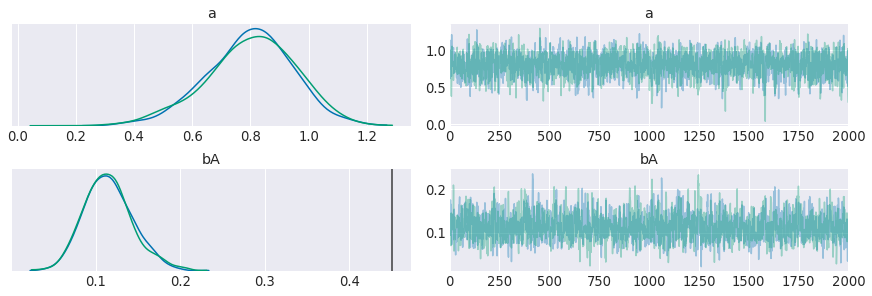

In [142]:
az.plot_trace(trace_eleph_error, var_names=["a", "bA"], lines=[("bA", {}, post_eleph["bA"].mean())]);

Ignoring the `age_est` parameters for the moment, the average association between `MATINGS` and `AGE` has been divided by 4 (but is still reliably positive). At first, this can seem surprising, as the measurement error is both symmetric and the same for all ages. So this is unlike the divorce rate example in the chapter in the sense that the error is uniform. So adding equal error to all of the predictor values shouldn’t have much impact. 

What probably happened however is that the simulated error here is so big with regards to the data that part of the information contained in `AGE` is now considered illusory (we'll touch on that again in the next exercise). This rings a bell form the chapter: in general, ignoring measurement error leads to exagerated associations between predictors and outcomes. 

Finally, note that chances are that real measurement error would not be uniform across all ages. It would be much easier to distinguish among young ages than older ages, for example.

Actually, we can learn something more in this example by inspecting the posterior distributions of the `AGE` values, the `age_est` parameters. Let’s extract them and compare the posterior means to the observed values. The plot I’ll construct will have `AGE` on the horizontal and `MATINGS` on the vertical, with open points for the inferred posterior means and filled blue points for the observed. I’ll connect each pair of points for the same animal with a line segment. Since so many points overlap, I’ll also add a little jitter to the vertical scale, so we can tell individuals apart more easily. Finally, I’ll plot the mean regression trend.

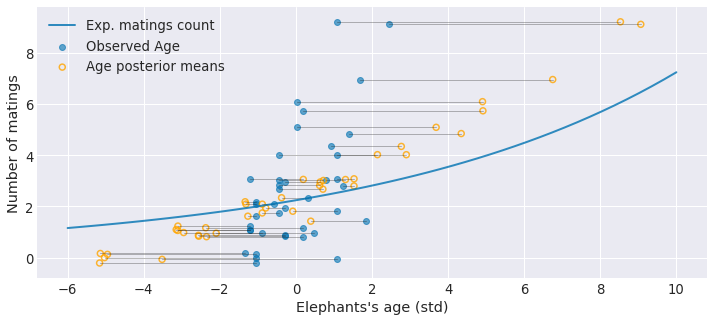

In [143]:
matings_j = np.random.normal(d.MATINGS, .2)
age_est_mean = post_eleph_error.filter(like="age_").mean().values
age_seq = np.linspace(-6, 10)

# lambda calcs
lambdas_post_pred = []
for age in age_seq:
    lambdas_post_pred.append(np.exp(post_eleph_error['a'] + post_eleph_error['bA']*age).values)
lambdas_post_pred = np.asarray(lambdas_post_pred).T

# plot
plt.figure(figsize=(12,5))

plt.scatter(d.AGE_STDZ.values, matings_j, label="Observed Age", alpha=0.6)
plt.scatter(age_est_mean, matings_j, label="Age posterior means", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)

# line segments
plt.plot([d.AGE_STDZ.values, age_est_mean], [matings_j, matings_j], 'k-', alpha=.3, lw=1)

# regression trend
plt.plot(age_seq, lambdas_post_pred.mean(axis=0), label="Exp. matings count", alpha=.8, lw=2)

plt.xlabel("Elephants's age (std)")
plt.ylabel("Number of matings")
plt.legend();

The key thing to notice here is that the observations above the regression trend have been adjusted upwards in the posterior distribution, while the observations below the trend have been adjusted downwards. Why? Consider an observed number of matings that is above the expectation for a given observed age. This puts the blue point above the regression trend. For this observed age, measured with error, the matings exceed what is expected for that age. So the model “realizes” that the actual age of that individual is probably above what was measured and entered into the data table. So the open points (inferred) above the trend are to the right of the blue points (measured). Likewise, a blue point below the regression trend has a number of matings below what is expected for the measured age. So the model realizes that the actual age is probably below the measured age. So the open points (inferred) below the trend are to the left of the blue points (measured). Notice also that blue points farther from the regression trend shrink farther towards it. This is pooling, as usual.

### 14H2.
*Repeat the model fitting problem above, now increasing the assumed standard error on `AGE`. How large does the standard error have to get before the posterior mean for the coefficient on `AGE` reaches zero?*

All that’s required to fit the new models is to adjust the 5 inside the distribution assigned to `AGE`. For example, let’s begin by doubling the standard error to 10. Note that increasing the standard error makes the posterior harder to sample from, so brace yourselves for longer sampling, large gelman-rubin statistics and numerous divergences... But, again, having informative priors will help us here.

In [2]:
d = pd.read_csv('../Data/elephants.csv', ';')
d["AGE_STDZ"] = stdz(d.AGE)

In [5]:
_, trace_big_error = eleph_with_error(error=10., tuning=5000)
az.summary(trace_big_error, credible_interval=0.89, round_to=2, var_names=["a", "bA"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_est, bA, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:13<00:00, 190.91draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.81,0.15,0.58,1.05,0.00,0.00,2062.54,2062.54,2121.63,1978.84,1.00
bA,0.05,0.04,0.02,0.09,0.01,0.01,10.79,10.79,36.05,14.44,1.06


The posterior mean for `bA` has gotten closer to zero, but it’s still reliably above zero. Let’s try doubling it again.

In [14]:
_, trace_big_error = eleph_with_error(error=20., tuning=10000)
az.summary(trace_big_error, credible_interval=0.89, round_to=2, var_names=["a", "bA"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_est, bA, a]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:19<00:00, 300.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.80,0.16,0.55,1.04,0.00,0.00,2903.11,2903.11,3006.44,2203.88,1.00
bA,0.01,0.03,-0.03,0.04,0.01,0.01,3.91,3.91,5.75,101.62,1.26


Now we're talking! The inferred relationship is essentially zero. Let's inspect the trace:

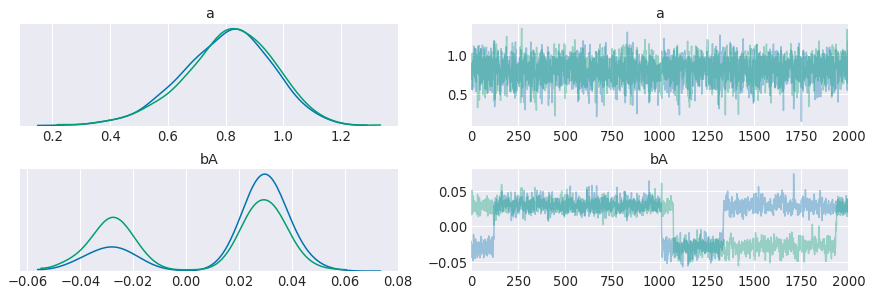

In [15]:
az.plot_trace(trace_big_error, var_names=["a", "bA"]);

There are now two modes in the posterior: A major mode above zero and a minor mode an equal distance below zero. The measurement error has gotten so large that it becomes possible that the relationship between age and matings is negative. But note that the majority of the probability mass remains above zero, although very close to it. If you inspect the trace plot for `bA` (right), you can see the chains switching between these two modes. This kind of posterior distribution is challenging to sample from. You’ll see another example in the next problem.

### 14H3.
*The fact that information flows in all directions among parameters sometimes leads to rather unintuitive conclusions. Here's an example from missing data imputation, in which imputation of a single datum reverses the direction of an inferred relationship. Use these data:*

In [2]:
x_cc = np.random.randn(10)
y_cc = np.random.normal(loc=x_cc)
x = np.concatenate((x_cc, np.NaN), axis=None)
y = np.concatenate((y_cc, 100.), axis=None)
x, y

(array([-0.41437255, -0.55203177, -1.69278599, -0.73479313, -0.28031203,
         1.01974458,  1.28710645, -1.6703349 ,  0.90370117,  0.38764572,
                nan]),
 array([  0.63335657,  -3.14889882,  -2.16832102,   0.2563943 ,
          1.70197695,   0.68671461,   2.96842533,  -1.30696418,
          0.91350587,   0.53390611, 100.        ]))

In [3]:
# masked array for missing values
mask = np.isfinite(x)
x[~mask] = -999
x = np.ma.masked_values(x, value=-999)

These data comprise 11 cases, one of which has a missing predictor value. You can quickly confirm that a regression of y on x for only the complete cases indicates a strong positive relationship between the two variables. But now fit this model, imputing the one missing value for x:

$$y_{i} \sim Normal(\mu_{i}, \sigma)$$

$$\mu_i = \alpha + \beta x_i$$

$$x_i \sim Normal(0, 1)$$

$$\alpha \sim Normal(0, 100)$$

$$\beta \sim Normal(0, 100)$$

$$\sigma \sim HalfCauchy(1)$$

What has happened to the posterior distribution of $\beta$? Be sure to inspect the full density. Can you explain the change in inference?

In [4]:
with pm.Model() as m_cc:
    a = pm.Normal("a", 0., 100.)
    b = pm.Normal("b", 0., 100.)
    
    mu = a + b*x_cc
    sigma = pm.HalfCauchy("sigma", beta=1.)
    
    y_obs = pm.Normal("y_obs", mu=mu, sd=sigma, observed=y_cc)
    
    trace_cc = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_cc, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 290.66draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.32,0.51,-0.43,1.13,0.01,0.01,1453.26,853.15,1615.46,998.96,1.0
b,1.23,0.50,0.49,2.01,0.01,0.01,1235.09,1235.09,1485.43,866.04,1.0
sigma,1.46,0.43,0.87,1.95,0.02,0.01,731.34,675.95,934.44,830.39,1.0


The association between x and y (the `b` coefficient above) is indeed reliably positive when fitting the model with only the complete cases. 
But what happens when we impute, using the known distribution for x. Here’s the model given in the problem:

In [5]:
with pm.Model() as m_full:
    a = pm.Normal("a", 0., 100.)
    b = pm.Normal("b", 0., 100.)
    
    x_est = pm.Normal("x_est", mu=0., sd=1., observed=x)
    mu = a + b*x_est
    sigma = pm.HalfCauchy("sigma", beta=1.)
    
    y_obs = pm.Normal("y_obs", mu=mu, sd=sigma, observed=y)
    
    trace_full = pm.sample(1000, cores=2, random_seed=RANDOM_SEED)

post_full = pm.trace_to_dataframe(trace_full)
az.summary(trace_full, credible_interval=0.89, round_to=2)

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in x_est contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, x_est_missing, b, a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 249.88draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,8.43,9.24,-7.07,22.17,0.27,0.21,1165.30,1006.01,1189.50,999.14,1.0
b,5.01,12.98,-16.63,23.47,0.48,0.34,746.03,746.03,793.97,1188.75,1.0
x_est_missing[0],0.48,1.53,-1.85,2.90,0.06,0.04,652.74,652.74,642.76,575.24,1.0
sigma,29.34,8.22,16.70,39.64,0.28,0.19,892.96,892.96,823.74,582.62,1.0


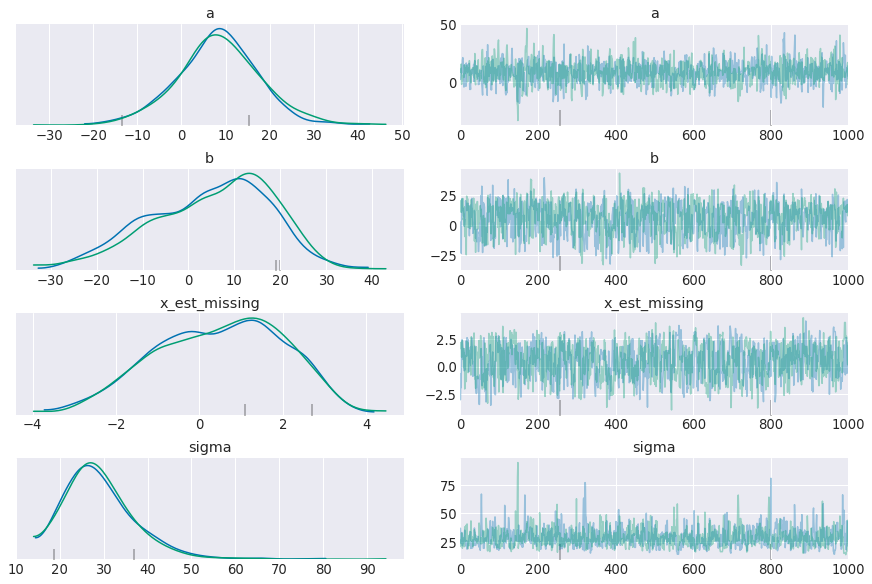

In [6]:
az.plot_trace(trace_full, compact=True);

Something weird is going on with both the imputed value, `x_est_missing`, and `b`. Look at the standard deviations and intervals. Let’s look at the posterior distribution, focusing on the joint distribution of `b` and `x_est_missing`:

In [7]:
def pair_plot_corr(df: pd.DataFrame):
    
    grid = (sns.PairGrid(df, diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))


def plot_corr(x, y, **kwargs):
    
    corrcoeff = np.corrcoef(x, y)[0, 1]
    if np.abs(corrcoeff) < .5:
        fsize = 12
    else:
        fsize = corrcoeff*30
    
    artist = AnchoredText("{:.2f}".format(corrcoeff), loc=10, frameon=False, prop=dict(fontsize=fsize, fontweight="bold"))
    plt.gca().add_artist(artist)
    plt.grid(b=False)

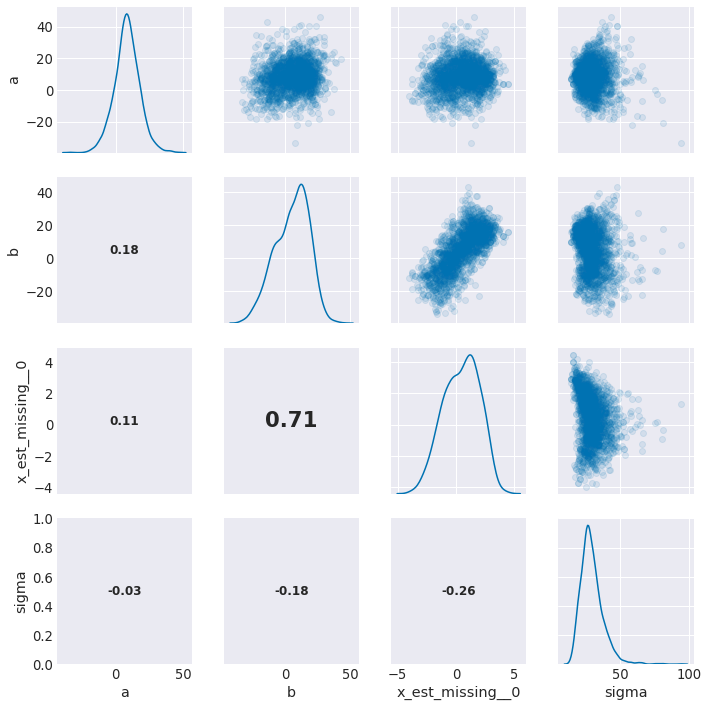

In [8]:
pair_plot_corr(post_full);

*A note before going on: due to randomness of sampling, it's possible you get bimodal posterior distributions for `b` and `x_est_missing` instead of the unimodal ones above. The exercise is actually designed to get bimodals, but I couldn't get them here - yeah, PyMC is *that* good at sampling! The following analysis and code should still be valid in both cases however.*

So, the posterior indicates that the plausible values of the `b` coefficient, conditional on the data and model, can go from strongly positive to equally strongly negative. Same thing for the posterior distribution of the missing $x$ value, `x_est_missing[0]`. And jointly, the large `b ` values go with the large `x_est_missing[0]` values (correlation of 0.69).

What has happened here? How has imputing a single missing $x$ changed inference so much? And why is the posterior so wide (or even bimodal)? Since a $y$ value of 100 is an extremely large value, only an extremely large $x$ value would be consistent with both that $y$ and the original posterior mean for $\beta$, around 1.2. So for $y = 100$, the $x$ consistent with the parameters (inferred ignoring the missing value) would be:

$$y =  \alpha + \beta x\quad$$
$$100 =  -0.41 + 1.21 x\quad$$
$$x = (100 + 0.41)\; /\; 1.21\quad$$
$$x = 83$$

But since the prior assigned to $x$ is relatively narrow (Normal(0, 1)), it is too implausible that the missing $x$ is as large as 83. So what are the alternatives? The posterior distribution has nominated them. Let’s plot each of the modes, in terms of the implied regression relationship.

So, let’s take the positive / negative `b` samples and plot the regression line for both, to see what each imply. We'll also plot the original $x$ values, as well the imputed $x$ value:

In [9]:
post_pos = post_full[post_full.b > 0]
post_neg = post_full[post_full.b < 0]

In [24]:
def link(post_df: pd.DataFrame, slope: str, x_seq: np.array, itcpt: str="a", link_fct=identity) -> np.array:
    """
    Returns the mean regression trend from a model's trace to inspect the inferred relationship between predictor and outcome.
    Limited to one predictor x_seq.
    Default link function is identity function, as in plain linear regression.
    """
    mus_post_pred = []
    for x_ in x_seq:
        mus_post_pred.append(link_fct(post_df[itcpt] + post_df[slope]*x_).values)
    
    return np.asarray(mus_post_pred).T


def identity(x):
    """Simple identity function"""
    return x

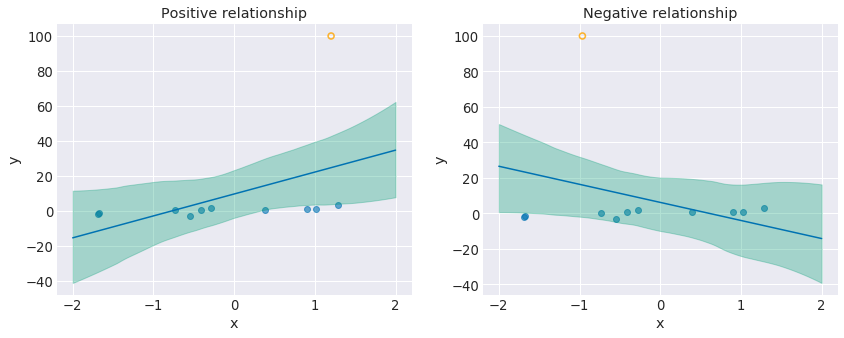

In [35]:
x_seq = np.linspace(-2, 2)
x_impute_pos = post_pos["x_est_missing__0"].mean()
x_impute_neg = post_neg["x_est_missing__0"].mean()

# lambda calcs
mus_pp_pos = link(post_pos, "b", x_seq)
mus_pp_neg = link(post_neg, "b", x_seq)
    
# plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(x_cc, y_cc, alpha=0.6)
ax1.scatter(x_impute_pos, 100., alpha=0.8, facecolors="none", edgecolors="orange", linewidths=1.6)
az.plot_hpd(x_seq, mus_pp_pos, credible_interval=0.89, fill_kwargs={"alpha": 0.3}, ax=ax1)
ax1.plot(x_seq, mus_pp_pos.mean(axis=0))
ax1.set(xlabel="x", ylabel="y", title="Positive relationship")

ax2.scatter(x_cc, y_cc, alpha=0.6)
ax2.scatter(x_impute_neg, 100., alpha=0.8, facecolors="none", edgecolors="orange", linewidths=1.6)
az.plot_hpd(x_seq, mus_pp_neg, credible_interval=0.89, fill_kwargs={"alpha": 0.3}, ax=ax2)
ax2.plot(x_seq, mus_pp_neg.mean(axis=0))
ax2.set(xlabel="x", ylabel="y", title="Negative relationship");

The only ways to make values of the missing $x$ that are consistent with the model and data is to have a strong positive or negative slope. Why? Because the missing $x$ has to be much closer to zero than the original $\beta$ value implied (see our little equation above). This forces a steep slope on any regression relationship that will include the case with the missing value, shown by the open point in both plots above. The positive relationship remains more plausible than the negative one though, because the other points (shown in blue) demonstrate a positive relationship between $y$ and $x$.

You may want to change the assumed distribution on $x$ in the model, to see what impact it has. You might even replace the mean and standard deviation of $x$ with parameters, like the imputation examples in the chapter.

In [36]:
import sys, IPython, scipy, matplotlib, platform
print(f"This notebook was created on a computer {platform.machine()}, using: "
      f"\nPython {sys.version[:5]}\nIPython {IPython.__version__}\nPyMC3 {pm.__version__}\nArviz {az.__version__}\nNumPy {np.__version__}"
      f"\nPandas {pd.__version__}\nSciPy {scipy.__version__}\nMatplotlib {matplotlib.__version__}\n")

This notebook was created on a computer x86_64, using: 
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
Arviz 0.4.1
NumPy 1.16.3
Pandas 0.24.2
SciPy 1.2.1
Matplotlib 3.0.3

